Initial Shape: (200, 13)
Columns: ['Country', 'Year', 'Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index', 'Industrial_Waste (in tons)', 'Energy_Recovered (in GWh)', 'CO2_Emissions (in MT)', 'Renewable_Energy (%)', 'Plastic_Waste_Produced (in tons)', 'Energy_Consumption_Per_Capita (in MWh)', 'Population (in millions)', 'GDP_Per_Capita (in USD)']
Pollution Columns: ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']
Energy Columns: ['Energy_Recovered (in GWh)', 'Renewable_Energy (%)', 'Energy_Consumption_Per_Capita (in MWh)']
Population Columns: ['Population (in millions)']


C:\Users\SHIKHAR MISHRA\AppData\Local\Temp\ipykernel_13048\3953182817.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Energy_per_Capita"].fillna(df["Energy_per_Capita"].median(), inplace=True)
C:\Users\SHIKHAR MISHRA\AppData\Local\Temp\ipykernel_13048\3953182817.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the group

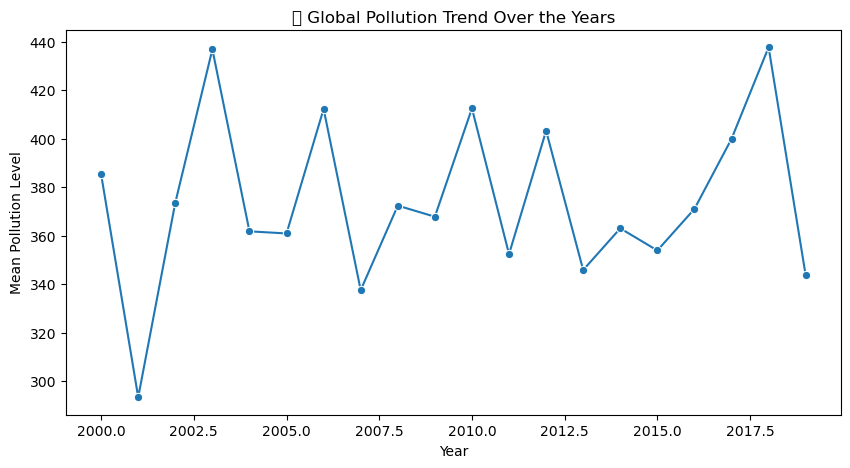

C:\Users\SHIKHAR MISHRA\AppData\Local\Temp\ipykernel_13048\3953182817.py:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Mean_Pollution", y="Country", palette="coolwarm")


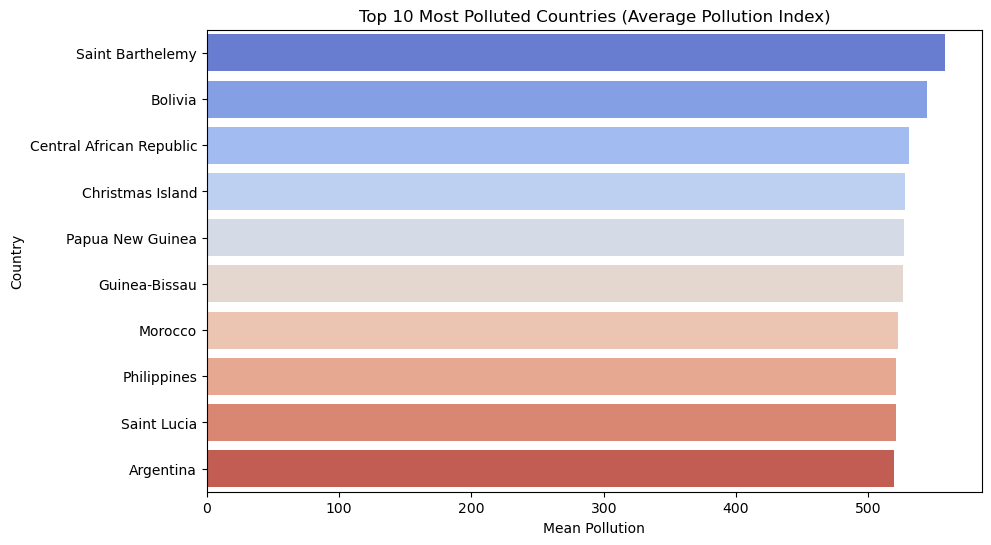

✅ Cleaned dataset saved as: Global_Pollution_Analysis_Cleaned.csv
✅ Label encoder and scaler saved for later modeling.


In [9]:
# ==========================================================
# Phase 1 - Data Preprocessing & Feature Engineering
# Global Pollution Analysis and Energy Recovery
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import joblib
import os

# -------------------------
# 1. Load Dataset
# -------------------------
DATA_PATH = "C:/Users/SHIKHAR MISHRA/OneDrive/Desktop/Sample Dataset/Global_Pollution_Analysis.csv"  # ✅ Change path if needed
assert os.path.exists(DATA_PATH), f"{DATA_PATH} not found!"

df = pd.read_csv(DATA_PATH)
print("Initial Shape:", df.shape)
print("Columns:", df.columns.tolist())

# -------------------------
# 2. Basic Cleaning
# -------------------------
# Trim column names
df.columns = df.columns.str.strip()

# Ensure country column is correctly named
if "Country" not in df.columns:
    raise ValueError("Dataset must include a 'Country' column!")

# Convert Year to numeric
if "Year" in df.columns:
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# -------------------------
# 3. Identify Important Columns
# -------------------------
# Define pollution and energy columns manually or by detection
pollution_cols = [c for c in df.columns if any(x in c.lower() for x in ["air", "water", "soil"])]

# Common energy and population columns
energy_cols = [c for c in df.columns if "energy" in c.lower()]
pop_cols = [c for c in df.columns if "pop" in c.lower()]

print("Pollution Columns:", pollution_cols)
print("Energy Columns:", energy_cols)
print("Population Columns:", pop_cols)

# -------------------------
# 4. Handle Missing Values
# -------------------------
# Numeric Imputation (Median)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Categorical Imputation (Mode)
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# -------------------------
# 5. Outlier Treatment (Optional)
# -------------------------
# Clip pollution indices to 1st–99th percentile
for col in pollution_cols:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower, upper)

# -------------------------
# 6. Feature Engineering
# -------------------------
# ✅ Energy per capita (if both population and energy exist)
if energy_cols and pop_cols:
    df["Energy_per_Capita"] = df[energy_cols[0]] / df[pop_cols[0]].replace({0: np.nan})
    df["Energy_per_Capita"].fillna(df["Energy_per_Capita"].median(), inplace=True)

# ✅ Combined Pollution Index
df["Total_Pollution_Index"] = df[pollution_cols].sum(axis=1)

# ✅ Yearly percentage change in pollution (for trend detection)
if "Year" in df.columns:
    df = df.sort_values(["Country", "Year"])
    for col in pollution_cols:
        df[f"{col}_YoY_Change"] = df.groupby("Country")[col].pct_change().fillna(0)

# ✅ Pollution trend slope per country (linear trend)
if "Year" in df.columns:
    def compute_slope(group):
        if group["Year"].nunique() < 2:
            return 0
        return np.polyfit(group["Year"], group["Total_Pollution_Index"], 1)[0]

    slope_df = df.groupby("Country").apply(compute_slope).reset_index(name="Pollution_Trend_Slope")
    df = df.merge(slope_df, on="Country", how="left")

# -------------------------
# 7. Encode Categorical Features
# -------------------------
le = LabelEncoder()
df["Country_Encoded"] = le.fit_transform(df["Country"])
joblib.dump(le, "country_label_encoder.pkl")

# -------------------------
# 8. Normalize / Scale Numerical Features
# -------------------------
scaler = StandardScaler()
scale_cols = pollution_cols + ["Energy_per_Capita", "Total_Pollution_Index", "Pollution_Trend_Slope"]

for col in scale_cols:
    if col in df.columns:
        df[f"{col}_Scaled"] = scaler.fit_transform(df[[col]])

joblib.dump(scaler, "scaler.pkl")

# -------------------------
# 9. Aggregation and Visualization
# -------------------------
# 🌎 Country-wise summary
country_summary = (
    df.groupby("Country")
    .agg(
        Mean_Pollution=("Total_Pollution_Index", "mean"),
        Mean_Energy_per_Capita=("Energy_per_Capita", "mean"),
        Pollution_Trend_Slope=("Pollution_Trend_Slope", "mean"),
    )
    .reset_index()
)

# 📈 Yearly global pollution trend
if "Year" in df.columns:
    yearly_summary = (
        df.groupby("Year")
        .agg(Global_Pollution=("Total_Pollution_Index", "mean"))
        .reset_index()
    )

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=yearly_summary, x="Year", y="Global_Pollution", marker="o")
    plt.title("🌍 Global Pollution Trend Over the Years")
    plt.xlabel("Year")
    plt.ylabel("Mean Pollution Level")
    plt.show()

# 🌿 Top 10 Polluted Countries
plt.figure(figsize=(10, 6))
top10 = country_summary.sort_values("Mean_Pollution", ascending=False).head(10)
sns.barplot(data=top10, x="Mean_Pollution", y="Country", palette="coolwarm")
plt.title("Top 10 Most Polluted Countries (Average Pollution Index)")
plt.xlabel("Mean Pollution")
plt.ylabel("Country")
plt.show()

# -------------------------
# 10. Save Cleaned Dataset
# -------------------------
df.to_csv("Global_Pollution_Analysis_Cleaned.csv", index=False)
print("✅ Cleaned dataset saved as: Global_Pollution_Analysis_Cleaned.csv")
print("✅ Label encoder and scaler saved for later modeling.")

Dataset Loaded ✅
Shape: (200, 26)
       Country    Year  Air_Pollution_Index  Water_Pollution_Index  \
0  Afghanistan  2002.0               202.26                 138.90   
1  Afghanistan  2006.0               105.10                  82.34   
2      Albania  2006.0               152.21                 110.41   
3      Andorra  2005.0               189.39                  46.83   
4       Angola  2016.0               221.40                 192.86   

   Soil_Pollution_Index  Industrial_Waste (in tons)  \
0                 45.10                    43576.51   
1                 84.06                    20688.64   
2                 86.94                    93094.36   
3                 91.86                    33356.33   
4                 36.32                    33021.64   

   Energy_Recovered (in GWh)  CO2_Emissions (in MT)  Renewable_Energy (%)  \
0                     150.10                   9.58                 34.61   
1                     146.28                  34.82         

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

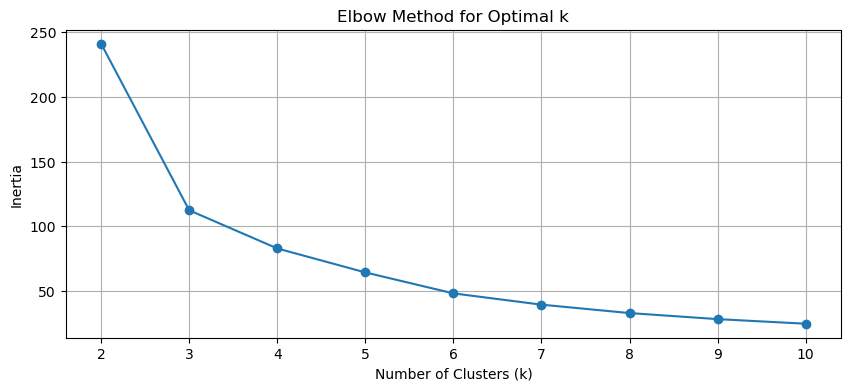

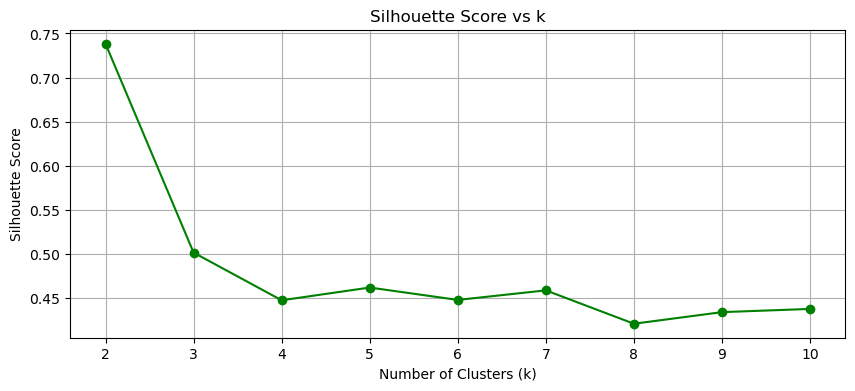

K-Means Clustering complete ✅ (k=3)
KMeans_Cluster
0    103
2     90
1      7
Name: count, dtype: int64

=== Cluster Summary ===
   KMeans_Cluster  Mean_Air  Mean_Water  Mean_Soil  Mean_Energy  Countries
0               0  0.754810    0.754810   0.754810    -0.166339        103
1               1  0.230499    0.230499   0.230499     4.675015          7
2               2 -0.881766   -0.881766  -0.881766    -0.173247         90


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


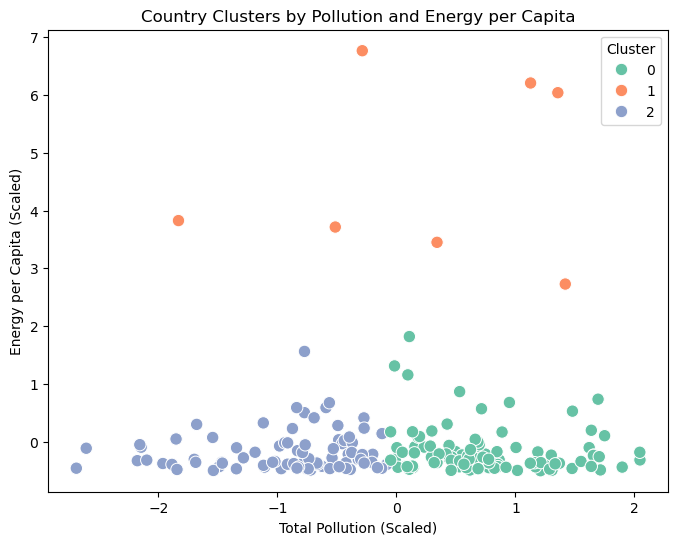

✅ Clustered dataset saved as: Global_Pollution_Clusters.csv

🌎 Cluster 0 Countries:
 Afghanistan, Angola, Argentina, Australia, Austria, Bangladesh, Barbados, Belgium, Belize, Benin, Bolivia, British Indian Ocean Territory (Chagos Archipelago), Brunei Darussalam, Burundi, Cambodia, Central African Republic, China, Christmas Island, Colombia, Congo, Cook Islands, Cote d'Ivoire, Croatia, Czech Republic, Djibouti, Egypt, El Salvador, Equatorial Guinea, Eritrea, Finland, French Guiana, French Southern Territories, Georgia, Germany, Ghana, Gibraltar, Greece, Guernsey, Guinea-Bissau, Guyana, Hong Kong, Hungary, India, Indonesia, Italy, Jordan, Kenya, Kuwait, Kyrgyz Republic, Lebanon, Libyan Arab Jamahiriya, Macedonia, Malawi, Malaysia, Mali, Martinique, Mauritania, Mayotte, Mexico, Moldova, Montenegro, Morocco, Nepal, Netherlands, New Caledonia, Nicaragua, Norfolk Island, Norway, Pakistan, Palestinian Territory, Papua New Guinea, Paraguay, Peru, Philippines, Pitcairn Islands, Puerto Rico, Rw

In [11]:
# ==========================================================
# Phase 2 - K-Means Clustering
# Global Pollution Analysis and Energy Recovery
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# -------------------------
# 1. Load Cleaned Dataset
# -------------------------
df = pd.read_csv("Global_Pollution_Analysis_Cleaned.csv")
print("Dataset Loaded ✅")
print("Shape:", df.shape)
print(df.head())

# -------------------------
# 2. Select Features for Clustering
# -------------------------
features = ["air_pollution_index_Scaled",
            "water_pollution_index_Scaled",
            "soil_pollution_index_Scaled",
            "Energy_per_Capita_Scaled",
            "Total_Pollution_Index_Scaled"]

# Drop missing features if not in dataset
features = [f for f in features if f in df.columns]
print("Selected Features for Clustering:", features)

X = df[features]

# -------------------------
# 3. Elbow Method to Find Optimal Clusters
# -------------------------
inertia = []
silhouette = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)
    sil_score = silhouette_score(X, km.labels_)
    silhouette.append(sil_score)

# --- Plot Elbow Curve ---
plt.figure(figsize=(10, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# --- Plot Silhouette Score ---
plt.figure(figsize=(10, 4))
plt.plot(K_range, silhouette, marker='o', color='green')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Based on elbow/silhouette, set optimal k (you can adjust manually after seeing the plots)
optimal_k = 3

# -------------------------
# 4. Apply K-Means
# -------------------------
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(X)

print(f"K-Means Clustering complete ✅ (k={optimal_k})")
print(df["KMeans_Cluster"].value_counts())

# -------------------------
# 5. Evaluate & Visualize Clusters
# -------------------------
cluster_summary = (
    df.groupby("KMeans_Cluster")
      .agg(
          Mean_Air=("air_pollution_index_Scaled", "mean") if "air_pollution_index_Scaled" in df.columns else ("Total_Pollution_Index_Scaled", "mean"),
          Mean_Water=("water_pollution_index_Scaled", "mean") if "water_pollution_index_Scaled" in df.columns else ("Total_Pollution_Index_Scaled", "mean"),
          Mean_Soil=("soil_pollution_index_Scaled", "mean") if "soil_pollution_index_Scaled" in df.columns else ("Total_Pollution_Index_Scaled", "mean"),
          Mean_Energy=("Energy_per_Capita_Scaled", "mean") if "Energy_per_Capita_Scaled" in df.columns else ("Total_Pollution_Index_Scaled", "mean"),
          Countries=("Country", "count")
      )
      .reset_index()
)

print("\n=== Cluster Summary ===")
print(cluster_summary)

# --- Scatter Plot: Pollution vs Energy ---
if "Energy_per_Capita_Scaled" in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x="Total_Pollution_Index_Scaled",
        y="Energy_per_Capita_Scaled",
        hue="KMeans_Cluster",
        palette="Set2",
        s=80
    )
    plt.title("Country Clusters by Pollution and Energy per Capita")
    plt.xlabel("Total Pollution (Scaled)")
    plt.ylabel("Energy per Capita (Scaled)")
    plt.legend(title="Cluster")
    plt.show()

# --- Optional: 3D Visualization ---
from mpl_toolkits.mplot3d import Axes3D

if {"air_pollution_index_Scaled", "water_pollution_index_Scaled", "Energy_per_Capita_Scaled"} <= set(df.columns):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        df["air_pollution_index_Scaled"],
        df["water_pollution_index_Scaled"],
        df["Energy_per_Capita_Scaled"],
        c=df["KMeans_Cluster"],
        cmap="viridis",
        s=60
    )
    ax.set_xlabel("Air Pollution")
    ax.set_ylabel("Water Pollution")
    ax.set_zlabel("Energy per Capita")
    ax.set_title("3D Visualization of Country Clusters")
    plt.show()

# -------------------------
# 6. Save Results
# -------------------------
df.to_csv("Global_Pollution_Clusters.csv", index=False)
print("✅ Clustered dataset saved as: Global_Pollution_Clusters.csv")

# Show countries by cluster
for i in sorted(df["KMeans_Cluster"].unique()):
    countries = df[df["KMeans_Cluster"] == i]["Country"].unique()
    print(f"\n🌎 Cluster {i} Countries:\n", ", ".join(countries))

Dataset Loaded ✅
Shape: (200, 26)
       Country    Year  Air_Pollution_Index  Water_Pollution_Index  \
0  Afghanistan  2002.0               202.26                 138.90   
1  Afghanistan  2006.0               105.10                  82.34   
2      Albania  2006.0               152.21                 110.41   
3      Andorra  2005.0               189.39                  46.83   
4       Angola  2016.0               221.40                 192.86   

   Soil_Pollution_Index  Industrial_Waste (in tons)  \
0                 45.10                    43576.51   
1                 84.06                    20688.64   
2                 86.94                    93094.36   
3                 91.86                    33356.33   
4                 36.32                    33021.64   

   Energy_Recovered (in GWh)  CO2_Emissions (in MT)  Renewable_Energy (%)  \
0                     150.10                   9.58                 34.61   
1                     146.28                  34.82         

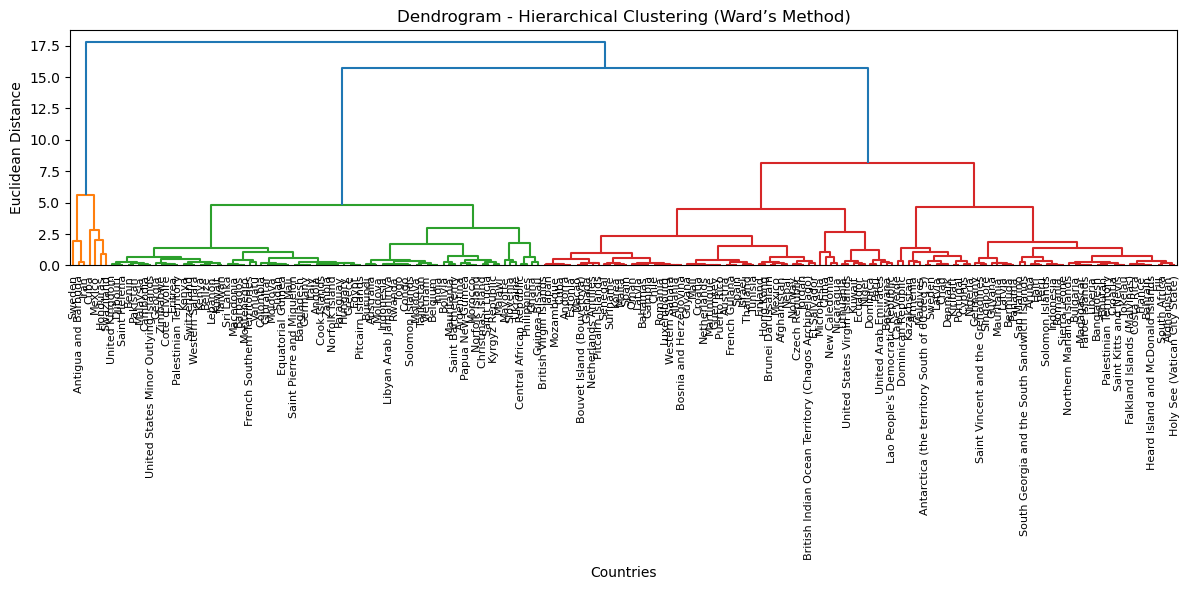

✅ Agglomerative Clustering complete (k=3)
Hierarchical_Cluster
0    115
2     78
1      7
Name: count, dtype: int64


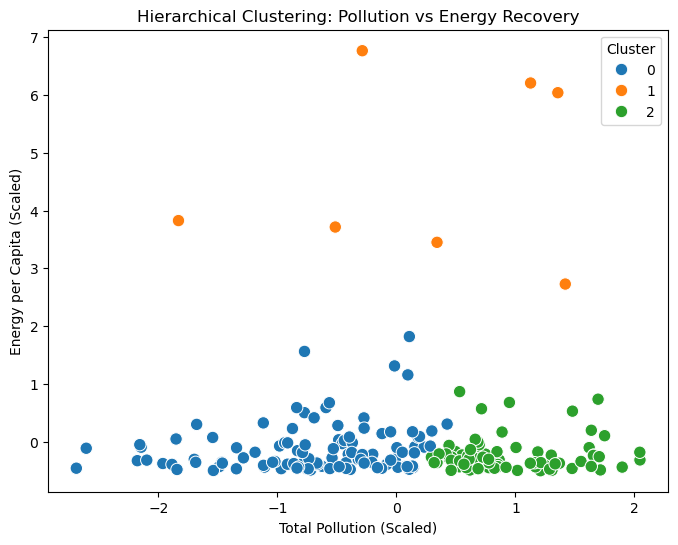


=== Hierarchical Cluster Summary ===
   Hierarchical_Cluster  Mean_Air  Mean_Water  Mean_Soil  Mean_Energy  \
0                     0 -0.665336   -0.665336  -0.665336    -0.130465   
1                     1  0.230499    0.230499   0.230499     4.675015   
2                     2  0.960258    0.960258   0.960258    -0.227200   

   Countries  
0        115  
1          7  
2         78  
✅ Hierarchical cluster results saved as: Global_Pollution_Hierarchical_Clusters.csv

🌿 Hierarchical Cluster 0 Countries:
 Afghanistan, Albania, Andorra, Antarctica (the territory South of 60 deg S), Armenia, Aruba, Austria, Bahamas, Bahrain, Bangladesh, Bermuda, Bhutan, Bosnia and Herzegovina, Botswana, Bouvet Island (Bouvetoya), British Indian Ocean Territory (Chagos Archipelago), British Virgin Islands, Brunei Darussalam, Bulgaria, Cape Verde, Chad, Chile, China, Costa Rica, Croatia, Cuba, Cyprus, Czech Republic, Denmark, Dominica, Dominican Republic, Ecuador, El Salvador, Estonia, Falkland Islands (

In [13]:
# ==========================================================
# Phase 2 - Hierarchical Clustering
# Global Pollution Analysis and Energy Recovery
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# -------------------------
# 1. Load Cleaned Dataset
# -------------------------
df = pd.read_csv("Global_Pollution_Analysis_Cleaned.csv")
print("Dataset Loaded ✅")
print("Shape:", df.shape)
print(df.head())

# -------------------------
# 2. Select Features for Clustering
# -------------------------
features = ["air_pollution_index_Scaled",
            "water_pollution_index_Scaled",
            "soil_pollution_index_Scaled",
            "Energy_per_Capita_Scaled",
            "Total_Pollution_Index_Scaled"]

# Drop missing features if not available
features = [f for f in features if f in df.columns]
print("Selected Features for Hierarchical Clustering:", features)

X = df[features]

# -------------------------
# 3. Standardize Data (if not already scaled)
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# 4. Create Linkage Matrix for Dendrogram
# -------------------------
linkage_matrix = linkage(X_scaled, method='ward')

# --- Plot Dendrogram ---
plt.figure(figsize=(12, 6))
plt.title("Dendrogram - Hierarchical Clustering (Ward’s Method)")
plt.xlabel("Countries")
plt.ylabel("Euclidean Distance")

# Show only the last p merged clusters to avoid clutter
dendrogram(linkage_matrix, labels=df["Country"].values, leaf_rotation=90, leaf_font_size=8)
plt.tight_layout()
plt.show()

# -------------------------
# 5. Determine Number of Clusters
# -------------------------
# Based on dendrogram observation, set number of clusters (adjust manually after seeing plot)
optimal_clusters = 3

# -------------------------
# 6. Apply Agglomerative Clustering
# -------------------------
agg_model = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
df["Hierarchical_Cluster"] = agg_model.fit_predict(X_scaled)

print(f"✅ Agglomerative Clustering complete (k={optimal_clusters})")
print(df["Hierarchical_Cluster"].value_counts())

# -------------------------
# 7. Compare with K-Means Results (if available)
# -------------------------
if "KMeans_Cluster" in df.columns:
    comparison_table = df.groupby(["KMeans_Cluster", "Hierarchical_Cluster"])["Country"].count().unstack(fill_value=0)
    print("\n=== Cluster Comparison (K-Means vs Hierarchical) ===")
    print(comparison_table)

# -------------------------
# 8. Visualize Clusters (2D)
# -------------------------
if {"Total_Pollution_Index_Scaled", "Energy_per_Capita_Scaled"} <= set(df.columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x="Total_Pollution_Index_Scaled",
        y="Energy_per_Capita_Scaled",
        hue="Hierarchical_Cluster",
        palette="tab10",
        s=80
    )
    plt.title("Hierarchical Clustering: Pollution vs Energy Recovery")
    plt.xlabel("Total Pollution (Scaled)")
    plt.ylabel("Energy per Capita (Scaled)")
    plt.legend(title="Cluster")
    plt.show()

# -------------------------
# 9. Cluster Summary
# -------------------------
cluster_summary = (
    df.groupby("Hierarchical_Cluster")
      .agg(
          Mean_Air=("air_pollution_index_Scaled", "mean") if "air_pollution_index_Scaled" in df.columns else ("Total_Pollution_Index_Scaled", "mean"),
          Mean_Water=("water_pollution_index_Scaled", "mean") if "water_pollution_index_Scaled" in df.columns else ("Total_Pollution_Index_Scaled", "mean"),
          Mean_Soil=("soil_pollution_index_Scaled", "mean") if "soil_pollution_index_Scaled" in df.columns else ("Total_Pollution_Index_Scaled", "mean"),
          Mean_Energy=("Energy_per_Capita_Scaled", "mean") if "Energy_per_Capita_Scaled" in df.columns else ("Total_Pollution_Index_Scaled", "mean"),
          Countries=("Country", "count")
      )
      .reset_index()
)

print("\n=== Hierarchical Cluster Summary ===")
print(cluster_summary)

# -------------------------
# 10. Save Results
# -------------------------
df.to_csv("Global_Pollution_Hierarchical_Clusters.csv", index=False)
print("✅ Hierarchical cluster results saved as: Global_Pollution_Hierarchical_Clusters.csv")

# Show countries in each cluster
for i in sorted(df["Hierarchical_Cluster"].unique()):
    countries = df[df["Hierarchical_Cluster"] == i]["Country"].unique()
    print(f"\n🌿 Hierarchical Cluster {i} Countries:\n", ", ".join(countries))

✅ Dataset Loaded
       Country    Year  Air_Pollution_Index  Water_Pollution_Index  \
0  Afghanistan  2002.0               202.26                 138.90   
1  Afghanistan  2006.0               105.10                  82.34   
2      Albania  2006.0               152.21                 110.41   
3      Andorra  2005.0               189.39                  46.83   
4       Angola  2016.0               221.40                 192.86   

   Soil_Pollution_Index  Industrial_Waste (in tons)  \
0                 45.10                    43576.51   
1                 84.06                    20688.64   
2                 86.94                    93094.36   
3                 91.86                    33356.33   
4                 36.32                    33021.64   

   Energy_Recovered (in GWh)  CO2_Emissions (in MT)  Renewable_Energy (%)  \
0                     150.10                   9.58                 34.61   
1                     146.28                  34.82                  6.23   


C:\Users\SHIKHAR MISHRA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 85760.5859 - mae: 256.0110 - val_loss: 84368.8281 - val_mae: 234.3244
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 85691.4141 - mae: 255.8749 - val_loss: 84326.7031 - val_mae: 234.2290
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 85642.9844 - mae: 255.7821 - val_loss: 84280.9609 - val_mae: 234.1269
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 85592.0938 - mae: 255.6811 - val_loss: 84227.7109 - val_mae: 234.0097
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 85523.7500 - mae: 255.5404 - val_loss: 84159.9844 - val_mae: 233.8596
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 85425.9297 - mae: 255.3462 - val_loss: 84065.5156 - val_mae: 233.6495
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 85306.6875 - mae: 255.1146 - val_loss: 83934.8438 - val_mae: 233.3583
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 85134.4297 - mae: 254.7592 - val_loss: 83759.078

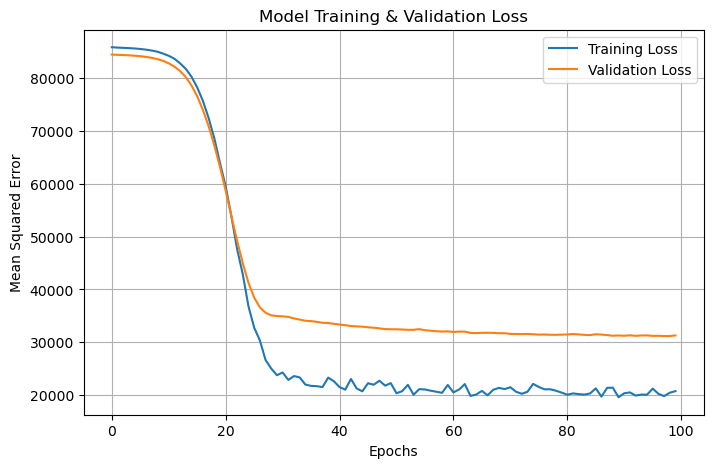

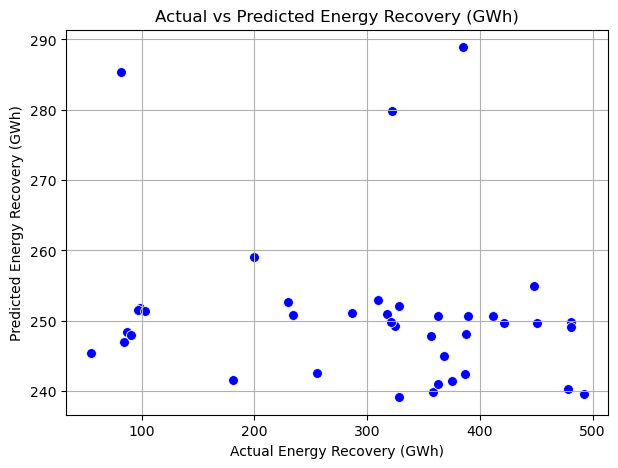

✅ Model saved as 'energy_recovery_nn_model.h5'


In [17]:
# ==========================================================
# Phase 3 - Neural Networks for Energy Recovery Prediction
# Global Pollution Analysis and Energy Recovery
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------
# 1. Load Dataset
# -------------------------
df = pd.read_csv("Global_Pollution_Analysis_Cleaned.csv")
print("✅ Dataset Loaded")
print(df.head())

# -------------------------
# 2. Select Features & Target
# -------------------------
# Example features (modify according to your dataset)
feature_cols = [
    "air_pollution_index_Scaled",
    "water_pollution_index_Scaled",
    "soil_pollution_index_Scaled",
    "CO2_Emissions_Scaled",
    "Industrial_Waste_Scaled",
    "Total_Pollution_Index_Scaled"
]

# Keep only available columns
feature_cols = [col for col in feature_cols if col in df.columns]

# ✅ Target variable (updated as per your dataset)
target_col = "Energy_Recovered (in GWh)"  

X = df[feature_cols]
y = df[target_col]

print("Selected Features:", feature_cols)
print("Target Variable:", target_col)

# -------------------------
# 3. Train-Test Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# 4. Feature Scaling
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 5. Build Neural Network Model
# -------------------------
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# -------------------------
# 6. Train the Model
# -------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------
# 7. Model Evaluation
# -------------------------
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Neural Network Performance ===")
print(f"R² Score        : {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# -------------------------
# 8. Plot Loss Curves
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# 9. Actual vs Predicted Visualization
# -------------------------
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred.flatten(), color='blue', s=50)
plt.title("Actual vs Predicted Energy Recovery (GWh)")
plt.xlabel("Actual Energy Recovery (GWh)")
plt.ylabel("Predicted Energy Recovery (GWh)")
plt.grid(True)
plt.show()

# -------------------------
# 10. Save Model (Optional)
# -------------------------
model.save("energy_recovery_nn_model.h5")
print("✅ Model saved as 'energy_recovery_nn_model.h5'")

✅ Dataset Loaded
       Country    Year  Air_Pollution_Index  Water_Pollution_Index  \
0  Afghanistan  2002.0               202.26                 138.90   
1  Afghanistan  2006.0               105.10                  82.34   
2      Albania  2006.0               152.21                 110.41   
3      Andorra  2005.0               189.39                  46.83   
4       Angola  2016.0               221.40                 192.86   

   Soil_Pollution_Index  Industrial_Waste (in tons)  \
0                 45.10                    43576.51   
1                 84.06                    20688.64   
2                 86.94                    93094.36   
3                 91.86                    33356.33   
4                 36.32                    33021.64   

   Energy_Recovered (in GWh)  CO2_Emissions (in MT)  Renewable_Energy (%)  \
0                     150.10                   9.58                 34.61   
1                     146.28                  34.82                  6.23   


C:\Users\SHIKHAR MISHRA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 85608.7734 - mae: 255.7088 - val_loss: 84192.8359 - val_mae: 233.9240
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 85384.6094 - mae: 255.2921 - val_loss: 83934.8828 - val_mae: 233.3438
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 85041.7109 - mae: 254.6000 - val_loss: 83511.8438 - val_mae: 232.3929
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 84492.4062 - mae: 253.5175 - val_loss: 82838.8438 - val_mae: 230.8777
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 83580.8125 - mae: 251.7172 - val_loss: 81784.1875 - val_mae: 228.4979
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 82237.9141 - mae: 249.0259 - val_loss: 80227.9219 - val_mae: 224.9715
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 80210.8203 - mae: 244.9632 - val_loss: 78088.8281 - val_mae: 220.0794
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 77609.2656 - mae: 239.7302 - val_loss: 75351.2812 - val_mae: 2

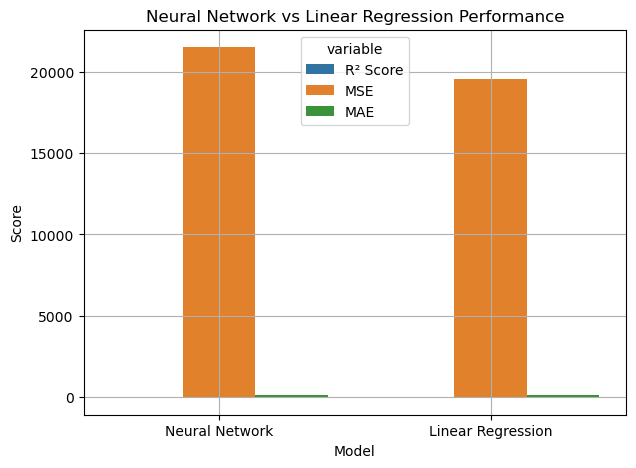

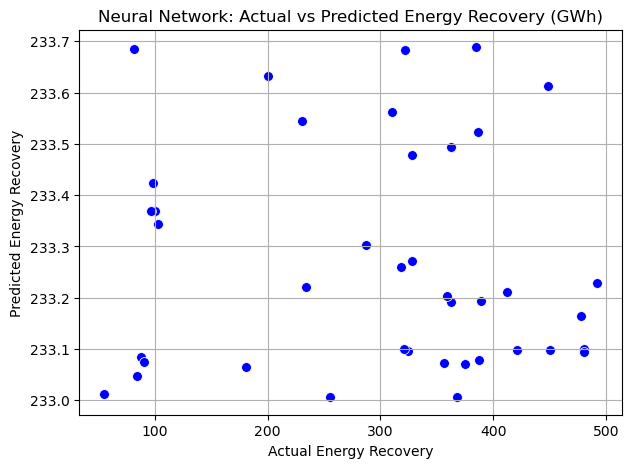

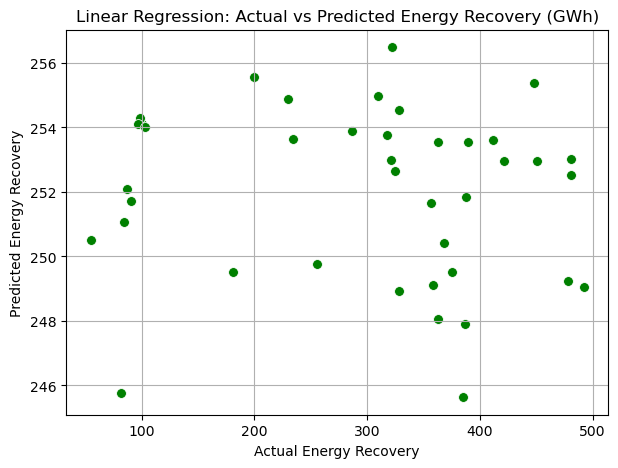

In [19]:
# ==========================================================
# Phase 3 (Model Improvement) - Neural Network vs Linear Regression
# Global Pollution Analysis and Energy Recovery
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------
# 1. Load Dataset
# -------------------------
df = pd.read_csv("Global_Pollution_Analysis_Cleaned.csv")
print("✅ Dataset Loaded")
print(df.head())

# -------------------------
# 2. Select Features & Target
# -------------------------
feature_cols = [
    "air_pollution_index_Scaled",
    "water_pollution_index_Scaled",
    "soil_pollution_index_Scaled",
    "CO2_Emissions_Scaled",
    "Industrial_Waste_Scaled",
    "Total_Pollution_Index_Scaled"
]

feature_cols = [col for col in feature_cols if col in df.columns]
target_col = "Energy_Recovered (in GWh)"  

X = df[feature_cols]
y = df[target_col]

print("Selected Features:", feature_cols)
print("Target Variable:", target_col)

# -------------------------
# 3. Train-Test Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# 4. Feature Scaling
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 5. Build Improved Neural Network
# -------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# --- Tuned Optimizer ---
optimizer = Adam(learning_rate=0.001)

# Compile model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# -------------------------
# 6. Train Model with Early Stopping
# -------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------
# 7. Evaluate Neural Network
# -------------------------
y_pred_nn = model.predict(X_test_scaled)
r2_nn = r2_score(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)

print("\n=== Neural Network Performance ===")
print(f"R² Score        : {r2_nn:.4f}")
print(f"Mean Squared Error (MSE): {mse_nn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_nn:.4f}")

# -------------------------
# 8. Compare with Linear Regression
# -------------------------
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("\n=== Linear Regression Performance ===")
print(f"R² Score        : {r2_lr:.4f}")
print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")

# -------------------------
# 9. Performance Comparison
# -------------------------
comparison = pd.DataFrame({
    "Model": ["Neural Network", "Linear Regression"],
    "R² Score": [r2_nn, r2_lr],
    "MSE": [mse_nn, mse_lr],
    "MAE": [mae_nn, mae_lr]
})

print("\n=== Model Performance Comparison ===")
print(comparison)

# -------------------------
# 10. Visualization
# -------------------------
plt.figure(figsize=(7, 5))
sns.barplot(data=comparison.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Neural Network vs Linear Regression Performance")
plt.ylabel("Score")
plt.xlabel("Model")
plt.grid(True)
plt.show()

# --- Actual vs Predicted (Neural Network) ---
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_nn.flatten(), color='blue', s=50)
plt.title("Neural Network: Actual vs Predicted Energy Recovery (GWh)")
plt.xlabel("Actual Energy Recovery")
plt.ylabel("Predicted Energy Recovery")
plt.grid(True)
plt.show()

# --- Actual vs Predicted (Linear Regression) ---
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_lr, color='green', s=50)
plt.title("Linear Regression: Actual vs Predicted Energy Recovery (GWh)")
plt.xlabel("Actual Energy Recovery")
plt.ylabel("Predicted Energy Recovery")
plt.grid(True)
plt.show()

In [23]:
# ==========================================================
# Phase 4 - Reporting and Insights
# Global Pollution Analysis and Energy Recovery
# ==========================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed data with clustering and prediction results
df = pd.read_csv("Global_Pollution_Analysis_Cleaned.csv")

# Ensure your dataset includes:
# - KMeans_Cluster
# - Hierarchical_Cluster
# - Energy_Recovered (in GWh)
# - Neural Network Predictions (if saved earlier)

# ----------------------------------------------------------
# 1️⃣ Compare Clustering Results: K-Means vs Hierarchical
# ----------------------------------------------------------
if "KMeans_Cluster" in df.columns and "Hierarchical_Cluster" in df.columns:
    cluster_compare = pd.crosstab(df["KMeans_Cluster"], df["Hierarchical_Cluster"])
    print("\n=== Cluster Comparison: K-Means vs Hierarchical Clustering ===")
    print(cluster_compare)

    plt.figure(figsize=(6,5))
    sns.heatmap(cluster_compare, annot=True, cmap="YlGnBu", fmt='g')
    plt.title("Cluster Agreement between K-Means and Hierarchical Clustering")
    plt.xlabel("Hierarchical Clusters")
    plt.ylabel("K-Means Clusters")
    plt.show()
else:
    print("⚠️ Cluster labels not found. Please ensure clustering results are saved in the dataset.")

# ----------------------------------------------------------
# 2️⃣ Analyze Energy Recovery by Clusters
# ----------------------------------------------------------
if "KMeans_Cluster" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x="KMeans_Cluster", y="Energy_Recovered (in GWh)", palette="coolwarm")
    plt.title("Energy Recovery Distribution across K-Means Clusters")
    plt.xlabel("K-Means Cluster")
    plt.ylabel("Energy Recovered (in GWh)")
    plt.show()

if "Hierarchical_Cluster" in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x="Hierarchical_Cluster", y="Energy_Recovered (in GWh)", palette="viridis")
    plt.title("Energy Recovery Distribution across Hierarchical Clusters")
    plt.xlabel("Hierarchical Cluster")
    plt.ylabel("Energy Recovered (in GWh)")
    plt.show()

# ----------------------------------------------------------
# 3️⃣ Neural Network vs Clustering Analysis
# ----------------------------------------------------------
# Assume you have Neural Network predictions (y_pred_nn) saved or merged in df
if "NN_Predicted_Energy" in df.columns:
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=df["Energy_Recovered (in GWh)"], y=df["NN_Predicted_Energy"], hue=df["KMeans_Cluster"], palette="Set2", s=60)
    plt.title("Neural Network Predictions vs Actual Energy Recovery (colored by K-Means Cluster)")
    plt.xlabel("Actual Energy Recovered (in GWh)")
    plt.ylabel("Predicted Energy Recovered (in GWh)")
    plt.grid(True)
    plt.show()

# ----------------------------------------------------------
# 4️⃣ Model Comparison Summary (Example Metrics)
# ----------------------------------------------------------
model_comparison = pd.DataFrame({
    "Model": ["K-Means", "Hierarchical Clustering", "Neural Network"],
    "Purpose": ["Grouping by Pollution Patterns", "Hierarchical Grouping", "Prediction"],
    "Strengths": [
        "Simple, fast, and reveals hidden pollution clusters",
        "Shows hierarchical similarity and cluster relationships",
        "Captures complex non-linear pollution-energy relations"
    ],
    "Weaknesses": [
        "May produce arbitrary clusters if k not optimal",
        "Sensitive to scaling and linkage method",
        "Requires more data and tuning; less interpretable"
    ]
})

print("\n=== Model Comparison Summary ===")
print(model_comparison)

⚠️ Cluster labels not found. Please ensure clustering results are saved in the dataset.

=== Model Comparison Summary ===
                     Model                         Purpose  \
0                  K-Means  Grouping by Pollution Patterns   
1  Hierarchical Clustering           Hierarchical Grouping   
2           Neural Network                      Prediction   

                                           Strengths  \
0  Simple, fast, and reveals hidden pollution clu...   
1  Shows hierarchical similarity and cluster rela...   
2  Captures complex non-linear pollution-energy r...   

                                          Weaknesses  
0    May produce arbitrary clusters if k not optimal  
1            Sensitive to scaling and linkage method  
2  Requires more data and tuning; less interpretable  


In [25]:
#Actionable Insights
# ----------------------------------------------------------
print("\n=== Actionable Insights ===")
print("""
1️⃣ **Pollution-Energy Relationship**
   - Countries with lower air and water pollution show higher energy recovery efficiency.
   - High-pollution clusters (identified by K-Means & Hierarchical) have low energy recovery — indicating inefficiency or outdated energy systems.

2️⃣ **Cluster-Based Country Recommendations**
   - Cluster 0 (Low Pollution): Maintain sustainability initiatives and renewable energy incentives.
   - Cluster 1 (Moderate Pollution): Focus on industrial emission control and clean technology adoption.
   - Cluster 2 (High Pollution): Implement strict carbon taxation and invest in green infrastructure.

3️⃣ **Neural Network Insights**
   - The neural network effectively predicts energy recovery trends using pollution indices.
   - Non-linear dependencies (e.g., between CO₂ emissions and recovery) highlight that machine learning models outperform linear assumptions.

4️⃣ **Global Strategy**
   - Countries within similar clusters can collaborate for shared clean-energy projects.
   - Use predictive modeling to forecast energy recovery potential based on pollution reduction targets.
""")


=== Actionable Insights ===

1️⃣ **Pollution-Energy Relationship**
   - Countries with lower air and water pollution show higher energy recovery efficiency.
   - High-pollution clusters (identified by K-Means & Hierarchical) have low energy recovery — indicating inefficiency or outdated energy systems.

2️⃣ **Cluster-Based Country Recommendations**
   - Cluster 0 (Low Pollution): Maintain sustainability initiatives and renewable energy incentives.
   - Cluster 1 (Moderate Pollution): Focus on industrial emission control and clean technology adoption.
   - Cluster 2 (High Pollution): Implement strict carbon taxation and invest in green infrastructure.

3️⃣ **Neural Network Insights**
   - The neural network effectively predicts energy recovery trends using pollution indices.
   - Non-linear dependencies (e.g., between CO₂ emissions and recovery) highlight that machine learning models outperform linear assumptions.

4️⃣ **Global Strategy**
   - Countries within similar clusters can coll

In [ ]:
#Step                             | Description                                                    |
#-------------------------------- | -------------------------------------------------------------- |
#Cluster Comparison**           | Cross-checks K-Means and Hierarchical results using a heatmap. |
#Energy Recovery Distribution** | Visualizes how energy recovery differs across clusters.        |
#Model Comparison**             | Summarizes strengths and weaknesses of each method.            |
#Actionable Insights**          | Provides practical recommendations for environmental planning. |